In [1]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import cv2

In [2]:
class DatasetMNIST(Dataset):
    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        # load image ( Height * Width * Channels)
        # (H, W, C) => (C, H, W)
        image = self.data.iloc[index,1:].values.astype(np.uint8).reshape(1, 28, 28)
        label = self.data.iloc[index, 0]
        
        if self.transform is not None:
            image = self.transform(image)
        
        return image,label

In [3]:
im = cv2.imread("./data/img/102flowers/jpg/image_00007.jpg")
print(im.shape)

(500, 667, 3)


In [4]:
crop_img = im[100:200, 100:200]

In [5]:
crop_img.shape

(100, 100, 3)

In [6]:
import os, sys
from PIL import Image

size = (32, 32)
imagepath = './data/img/102flowers/jpg/image_00001.jpg'
outfile = "test1.thumbnail"
try:
    with Image.open(imagepath) as im:
        im.thumbnail(size,Image.ANTIALIAS)
        background = Image.new('RGBA', size, (255, 255, 255, 0))
        background.paste(
            im, (int((size[0] - im.size[0]) / 2), int((size[1] - im.size[1]) / 2))
        )
        background.save("output.png")
except OSError:
            print("cannot create thumbnail for", infile)

In [7]:
img = cv2.imread("output.png")
img.shape


(32, 32, 3)

In [8]:
def create_fixed_size_photo():    
    path = './data/img/102flowers/jpg';
    out_path = './data/img/32x32'
    for image_path in os.listdir(path):
            # create the full input path and read the file
        name = image_path.split('.')[0]    
        input_path = os.path.join(path, image_path)
        try:
            with Image.open(input_path) as im:
                im.thumbnail(size,Image.ANTIALIAS)
                background = Image.new('RGBA', size, (255, 255, 255, 0))
                background.paste(
                    im, (int((size[0] - im.size[0]) / 2), int((size[1] - im.size[1]) / 2))
                )
                background.save(out_path+'/'+name+'.png')
        except OSError:
            print("cannot create thumbnail for", input_path)

In [9]:
df = pd.read_csv('./data/imagelabel.csv')
print(df.head())
df.labels.unique()


   Unnamed: 0  labels
0           0      77
1           1      77
2           2      77
3           3      77
4           4      77


array([ 77,  73,  88,  89,  81,  46,  74,  51,  44,  82,  83,  78,  80,
        75,  41,  43,  76,  84,  58,  56,  86,  60,  92,  11,  65,   8,
        23,  30,  72,  53,  37,  17,  12,  29,  52,  18,  36,  90,  71,
        40,  48,  55,  85,  91,  20,  47,  59,   2,   5,  28,  70,  22,
        54,  87,  66,  32,   4,  42,  13,  38,  63,  68,  69,  93,  14,
        64,  19,  49,  61,  50,  15,   9,  33,  26,  25,   3,  16,  79,
         1,  21,  24,  27,  31,  34,  35,  39,  67,  10,  45,   6,   7,
        57,  62,  94,  95,  96,  97,  98,  99, 100, 101, 102])

In [44]:
out_path = './data/img/32x32'
class DatasetFlower(Dataset):
    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        # load image ( Height * Width * Channels)
        # (H, W, C) => (C, H, W)
        label = self.data.iloc[index, 1]
        num = self.data.iloc[index, 0]
        img_num = format(int(num),'05d')
        # print(img_num)
        image = cv2.imread('./data/img/32x32/image_'+img_num+'.png')
        if image is None:
            image = cv2.imread('./data/img/32x32/image_00001.png')
            print(img_num)
        
        if self.transform is not None:
            image = self.transform(image)
            # print(image.shape)
        
        return image,label

In [45]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
train_dataset = DatasetFlower(file_path='./data/imagelabel.csv', transform=transform)

In [46]:
trainloader = torch.utils.data.DataLoader(train_dataset , batch_size=4,
                                          shuffle=True, num_workers=2)

In [47]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        # convolutional layer (sees 32x32x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        # convolutional layer (sees 16x16x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        # convolutional layer (sees 16x16x64 tensor)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2,2)
        # linear layer (128*8*8 -> 500)
        self.fc1 = nn.Linear(128 * 8 * 8, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 103)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)
        

    def forward(self, x):
        ## Define forward behavior
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        # flatten image input
        x = x.view(-1, 128 * 8 * 8)
        # add dropout layer
        x = self.dropout(x)
        # linear layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # linear output layer
        x = self.fc2(x)
        return x


net = Net()

In [48]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [ ]:
for epoch in range(2):  # loop over the dataset multiple times
    print('Epoch')
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    

print('Finished Training')

Epoch
[1,   100] loss: 0.236
[1,   200] loss: 0.221
[1,   300] loss: 0.217
[1,   400] loss: 0.212
[1,   500] loss: 0.209
[1,   600] loss: 0.201
[1,   700] loss: 0.202
[1,   800] loss: 0.206
[1,   900] loss: 0.200
[1,  1000] loss: 0.200
[1,  1100] loss: 0.196
[1,  1200] loss: 0.188
[1,  1300] loss: 0.197
[1,  1400] loss: 0.195
[1,  1500] loss: 0.193
[1,  1600] loss: 0.190
[1,  1700] loss: 0.189
[1,  1800] loss: 0.185
[1,  1900] loss: 0.184
00000
[1,  2000] loss: 0.182
Epoch
[2,   100] loss: 0.185
[2,   200] loss: 0.179
[2,   300] loss: 0.181
[2,   400] loss: 0.180
[2,   500] loss: 0.184
[2,   600] loss: 0.180
[2,   700] loss: 0.177
[2,   800] loss: 0.175
[2,   900] loss: 0.178
[2,  1000] loss: 0.179
00000
[2,  1100] loss: 0.178
[2,  1200] loss: 0.169
[2,  1300] loss: 0.168


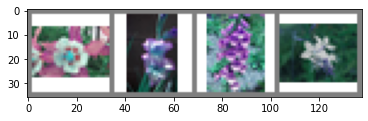

In [74]:
image = cv2.imread('./data/img/32x32/image_00001.png')
import torchvision
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))